# Similarity between genres of books

### Importing of Libraries and Reading of Data

In [1]:
import re
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import repeat
from sklearn.feature_extraction import stop_words
from collections import Counter
from operator import itemgetter


pd.set_option('display.max_colwidth', -1)

In [2]:
df= pd.read_csv('okadabooks_main.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 9 columns):
Unnamed: 0    14803 non-null int64
Title         14803 non-null object
Author        14803 non-null object
Genre         14803 non-null object
Price         14803 non-null int64
Reads         14803 non-null int64
Ratings       14803 non-null float64
Booklink      14803 non-null object
Blurb         14802 non-null object
dtypes: float64(1), int64(3), object(5)
memory usage: 1.0+ MB


In [4]:
df=df.dropna()
df= df.drop(columns= 'Unnamed: 0')

### Dropping duplicated Blurbs

**<u>Definition of Blurb: </u>**  
A blurb is a short description of a book, film, or other product written for promotional purposes.

Dropping blurb duplicates to increase accuracy of result. An example of what can cause a duplicated blurb is when an author publishes a preview of a novel and the novel itself (both at different Prices) with the same Blurb. All duplicates are in the same category with the original.

**N/B: In this notebook, THE words "category" and "genre" of books will be used interchangeably.**

In [5]:
df= df.drop_duplicates(subset=['Blurb'], keep= 'first')

In [6]:
len(df)

14395

### Normalizing the blurb 

Normalizing of the blurb column by getting rid of special characters and changing all letters to lower cases. All functions will be done on the norm_blurb column

In [7]:
df['norm_blurb']= df.Blurb
df.norm_blurb= df.norm_blurb.astype(str)

In [8]:
## change all capital letters to small letters
df.norm_blurb= df.norm_blurb.apply(lambda x: x.lower())
df['norm_blurb'] = df.norm_blurb.map(lambda x: x.replace('\r\r\r\r\n', ' '))
df['norm_blurb'] = df.norm_blurb.map(lambda x: x.replace('.', ' '))
df['norm_blurb'] = df.norm_blurb.map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df['norm_blurb'] = df.norm_blurb.map(lambda x: x.replace('  ', ' '))
df['norm_blurb'] = df.norm_blurb.map(lambda x: re.sub(r'[^\w]', ' ', x)) ##takes care of anything not alpha numeric like symbols ❤️ [14783]
df['norm_blurb'] = df.norm_blurb.map(lambda x: x.translate(str.maketrans('', '', string.digits)))

In [9]:
df.head(2)

,Title,Author,Genre,Price,Reads,Ratings,Booklink,Blurb,norm_blurb
0,the long walk,Milton J Davis,science_fiction,360,0,0.0,https://okadabooks.com/book/about/the_long_walk/29737,"Patience de Verteuil left her home in Trinidad with her father for what she thought would be a short journey to America. Instead she finds herself embroiled in a struggle between powerful supernatural forces, in which an object in her possession means the difference between defeat or victory. The Long Walk is a Steamfunk tale that will stay with you long after the final words are read.",patience de verteuil left her home in trinidad with her father for what she thought would be a short journey to america instead she finds herself embroiled in a struggle between powerful supernatural forces in which an object in her possession means the difference between defeat or victory the long walk is a steamfunk tale that will stay with you long after the final words are read
1,bilisi: rebirth of the orisha #1.,Tomi Adegbite.,science_fiction,1500,0,0.0,https://okadabooks.com/book/about/bilisi_rebirth_of_the_orisha_1/29663,"Enter a world or two of pure fantasy and wonder, as Bilisi Soneye discovers herself in more than one reality.",enter a world or two of pure fantasy and wonder as bilisi soneye discovers herself in more than one reality


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14395 entries, 0 to 14802
Data columns (total 9 columns):
Title         14395 non-null object
Author        14395 non-null object
Genre         14395 non-null object
Price         14395 non-null int64
Reads         14395 non-null int64
Ratings       14395 non-null float64
Booklink      14395 non-null object
Blurb         14395 non-null object
norm_blurb    14395 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 1.1+ MB


In [11]:
print('The total number of words in the norm_blurb column is ', sum(df.norm_blurb.map(lambda x: len(x.split())))/ 1000000," Million")

The total number of words in the norm_blurb column is  1.119537  Million


There are 1M+ words left after special characters, punctuation and numbers have been removed from the normalized blurb column. The words will then be used to check similarity metrics between genres. 

## Selection of the genres to be used

In okadabooks.com where the data used for this analysis was scraped, There are 22 categories whcih are called genre here. A quick look that the no of rows and columns throughout the dataframe will help to choose genres with more words which will in turn help increase the accuracy of this analysis. 
I am choosing four categories/genres here.

In [12]:
print(df.Genre.unique()) ###View all the categories of books in okadabokks.com

['science_fiction' 'business_finance' 'religion_and_beliefs' 'self_help'
 'mystery' 'educational' 'memoir' 'fiction' 'non-fiction' 'health_living'
 'other' 'children' 'romance' 'adventure' 'free' 'raw_unpublished_works'
 'comics' 'history' 'drama' 'poetry' 'humor' 'erotic']


In [13]:
def print_list():
    dash= "-"*100
    print(dash)
    print('{:<1s}{:>40s}{:>50s}'.format("Category"," #Books","#Total Words in all Blurbs"))
    print (dash)
    for i in df.Genre.unique():
        no_rows= len(df[df.Genre==i])
        no_words= sum(df[df.Genre==i].norm_blurb.map(lambda x: len(x.split())))
        print('{:<20s}{:^50d}{:>20d}'.format(i, no_rows,no_words))
    print(dash)
    print('{:<20s}{:^50d}{:>21d}'.format("Total",len(df),sum(df.norm_blurb.map(lambda x: len(x.split())))))
    print(dash)

In [14]:
print_list()

----------------------------------------------------------------------------------------------------
Category                                  #Books                        #Total Words in all Blurbs
----------------------------------------------------------------------------------------------------
science_fiction                            307                                       18758
business_finance                           570                                       66651
religion_and_beliefs                       1299                                     159460
self_help                                  1194                                     143485
mystery                                    500                                       35135
educational                                728                                       67557
memoir                                     131                                       13189
fiction                                    1727               

From a quick look at the number of words across the genres, You can notice some have more words compared to the others. I decided to go with genres that have a better probability of giving a better/more accurate result. I choose genres with a least a 100,000 of words in their Blurbs. Romance, self_help, religion_and_beliefs, fiction and a data frame containing 2000 random rows from the four of them will be used. I am going to create seperate tables for them. 

In [15]:
romance_df= df[df.Genre=="romance"]
selfhelp_df= df[df.Genre=="self_help"]
religion_df= df[df.Genre=="religion_and_beliefs"]
fiction_df= df[df.Genre=="fiction"]
random_df =  df[ (df.Genre== 'romance') | (df.Genre=="self_help") | (df.Genre=="religion_and_beliefs") | (df.Genre=="fiction")]

In [16]:
##Data frame containing 2000 random rows from either romance_df, selfhelp_df, religion_df or fiction_df
random_df = random_df.sample(2000)
len(random_df)

2000

In [17]:
random_df.head(2)

,Title,Author,Genre,Price,Reads,Ratings,Booklink,Blurb,norm_blurb
10055,ballagazar mace,MS SAIF,romance,200,0,0.0,https://okadabooks.com/book/about/ballagazar_mace/28347,Littafinnan yazo maku ne daga shafin www.hausaebooks.com.ng,littafinnan yazo maku ne daga shafin www hausaebooks com ng
10909,approved pre marriage maintenance - adult only (18+),Nwankwo Chima,romance,100,2,0.0,https://okadabooks.com/book/about/approved_pre_marriage_maintenance_-_adult_only_18%2B/15253,"Are you planning to get married any time in future? Do you have idea of what pre marriage counseling is all about? Learn what you need to know about pre marriage counseling. This style of counseling is becoming more popular in current times and is usually popularly backed by various religions and governmental agencies. This is primarily to create a better understanding and acceptance of what it entails to be part of a lasting relationship. \r\r\r\r\nThe main idea behind this particular exercise is also to limit the possibility of a high divorce rate and to try and keep couple together as a family unit for the betterment of the children.\r\r\r\r\nIn This Book, You Will Learn:\r\r\r\r\n* Counseling basics\r\r\r\r\n* Discussing finances\r\r\r\r\n* Discussing children\r\r\r\r\n* Discussing religion \r\r\r\r\n* Coming up with ground rules \r\r\r\r\nYou can't just go on without having this guide, don't wait till tomorrow, download it now!\r\r\r\r\n",are you planning to get married any time in future do you have idea of what pre marriage counseling is all about learn what you need to know about pre marriage counseling this style of counseling is becoming more popular in current times and is usually popularly backed by various religions and governmental agencies this is primarily to create a better understanding and acceptance of what it entails to be part of a lasting relationship the main idea behind this particular exercise is also to limit the possibility of a high divorce rate and to try and keep couple together as a family unit for the betterment of the children in this book you will learn counseling basics discussing finances discussing children discussing religion coming up with ground rules you cant just go on without having this guide dont wait till tomorrow download it now


## Eliminating stop words and creating a dictionary 

Stop words are the most common words in a language. In the English language, some examples of stop words are the, are, but, and they. Most sentences need to contain stop words in order to be full sentences that make sense. There are words that have no/little influence in semantic relationship. They include regular english expressions. 

Generally, stop words are removed because they aren’t significant and distort the word frequency analysis. In this analysis, all stop words will be removed.

In [18]:
print('Number of words in stopwords list:', len(stop_words.ENGLISH_STOP_WORDS))
print()
print('50 words on the stopwords list:', list(stop_words.ENGLISH_STOP_WORDS)[:50])

Number of words in stopwords list: 318

50 words on the stopwords list: ['done', 'here', 'cant', 'no', 'as', 'anywhere', 'around', 'there', 'describe', 'forty', 'beyond', 'one', 'thereafter', 'other', 'thick', 'was', 'though', 'after', 'con', 'mine', 'everyone', 'who', 'do', 'afterwards', 'never', 'inc', 'had', 'everything', 'nine', 'detail', 'until', 'for', 'among', 'ourselves', 'fill', 'an', 'hereafter', 'most', 'becoming', 'very', 'keep', 'off', 'four', 'has', 'sincere', 'un', 'third', 'thereby', 'sometimes', 'hundred']


In [19]:
def create_dict(norm_blurb):
    norm_blurb.astype(str)
    wordlist = [blurb.split(' ') for blurb in norm_blurb] # Create a list of lists (words in each review).
    wordlist = [word for blurb in wordlist for word in blurb] # Flatten the wordlist to create one list of all words in the reviews.
    vocab_dict = Counter(wordlist) # Create a Counter object (a dictionary of words and their frequencies).    
    for word in list(vocab_dict):
        if word in stop_words.ENGLISH_STOP_WORDS or word=='':
            del vocab_dict[word]
    return vocab_dict    


In [20]:
all_dict= create_dict(df.norm_blurb)
romance_dict= create_dict(romance_df.norm_blurb)
selfhelp_dict= create_dict(selfhelp_df.norm_blurb)
religion_dict= create_dict(religion_df.norm_blurb)
fiction_dict = create_dict(fiction_df.norm_blurb)
random_dict= create_dict (random_df.norm_blurb)

In [21]:
sum(df.norm_blurb.map(lambda x: len(x.split())))

1119537

In [22]:
print('Number of unique words in all genres:' , len(all_dict))
print('Number of unique words in all romance novels: ', len(romance_dict))
print('Number of unique words in all self help books: ', len(selfhelp_dict))
print('Number of unique words in all religious books: ', len(religion_dict))
print('Number of unique words in all fiction novels: ', len(fiction_dict))
print('Number of unique words in all random: ', len(random_dict))

Number of unique words in all genres: 51275
Number of unique words in all romance novels:  11828
Number of unique words in all self help books:  10880
Number of unique words in all religious books:  12104
Number of unique words in all fiction novels:  19282
Number of unique words in all random:  19802


In [23]:
print('Most commmon words in all genres:' , all_dict.most_common(10), '\n' ) 
print('Most commmon words in all romance novels: ', romance_dict.most_common(10), '\n')
print('Most commmon words in all self help books: ', selfhelp_dict.most_common(10), '\n')
print('Most commmon words in all religious books: ', religion_dict.most_common(10), '\n')
print('Most commmon words in all fiction novels: ', fiction_dict.most_common(10), '\n')
print('Most commmon words in all random: ', random_dict.most_common(10), '\n')

Most commmon words in all genres: [('book', 5923), ('life', 5290), ('da', 3294), ('s', 3030), ('love', 2955), ('god', 2718), ('story', 2467), ('people', 2172), ('time', 1967), ('ya', 1946)] 

Most commmon words in all romance novels:  [('love', 960), ('life', 416), ('s', 404), ('story', 289), ('da', 282), ('book', 248), ('man', 223), ('romance', 220), ('ta', 201), ('just', 176)] 

Most commmon words in all self help books:  [('book', 1349), ('life', 1240), ('time', 507), ('people', 426), ('make', 391), ('help', 338), ('success', 311), ('s', 310), ('know', 279), ('god', 268)] 

Most commmon words in all religious books:  [('god', 1660), ('book', 1330), ('life', 939), ('s', 464), ('church', 446), ('people', 365), ('jesus', 334), ('christ', 329), ('man', 326), ('world', 320)] 

Most commmon words in all fiction novels:  [('da', 1382), ('ta', 853), ('ya', 767), ('life', 688), ('story', 635), ('s', 551), ('love', 509), ('ba', 374), ('na', 357), ('young', 299)] 

Most commmon words in all ra

### Quick Deductions from the most common words in genres

From a quick look around through the 10 most common words in the four categories choosen, some deductions can be made:

* There is a lot of repeated words throughout the genres. The drastic difference between the total length of words in the norm_blurb and the Number of unique words explains this.

* God, christ,Jesus are the most common 10 words in the religious category. This was somewhat expected. It might also suggest that a lot of religious books are of christian religion.

* Success is mentioned a lot in self help books (also known as motivational books) which tend to preach motivate/ give tips for prosperity. 

* Love is the most common word in the romance genre. This concludes that blurbs are indeed an avid representation of the romance genre.

* Some of the words suggest there are many words with conjugtions, example dont's used in the blurb content

* There are more lexical terms in the religious books blurb/description which suggests that the average length of the number of words per book might be longer than the others. To look further into this, A function will be created to calculate the average length of words per blurb.

In [24]:
def mean_length(norm_blurb):
    review_lengths = []
    for review in norm_blurb:
        review_lengths.append(len(review.split(' ')))
    return sum(review_lengths)/len(review_lengths)

In [25]:
print('Average length of all genre blurb:', mean_length(df.norm_blurb))
print('Average length of romance novels blurb:', mean_length(romance_df.norm_blurb))
print('Average length of self help books blurb:', mean_length(selfhelp_df.norm_blurb))
print('Average length of religious books blurb:', mean_length(religion_df.norm_blurb))
print('Average length of fiction genre blurb:', mean_length(fiction_df.norm_blurb))
print('Average length of random genre blurb:', mean_length(random_df.norm_blurb))

Average length of all genre blurb: 81.0944772490448
Average length of romance novels blurb: 112.39161554192229
Average length of self help books blurb: 126.14405360134003
Average length of religious books blurb: 127.85065434949962
Average length of fiction genre blurb: 95.51650260567457
Average length of random genre blurb: 121.2825


## Similarity Metrics

### <u>Jaccard Similarity <u/>
The Jaccard similarity of two sets is the size of the intersection of the sets divided by the size of the union. Here, the relevant sets are the dictionaries for the various blurbs.

In [26]:
## Quick example:
A = {3, 4, 5}
B = {4, 5, 6}
print(A.intersection(B), A.union(B))
print('Jaccard similarity between A and B is', len(A.intersection(B))/ len(A.union(B)))

{4, 5} {3, 4, 5, 6}
Jaccard similarity between A and B is 0.5


#### Jaccard Function

In [27]:
def jaccard_similarity(genre1, genre2):
    intersection = len(set(genre1).intersection(set(genre2)))
    union = len(set(genre1).union(set(genre2)))
    return intersection/union

**ROMANCE**

This is to find similarities between romance and the other three genres

In [28]:
jaccard_similarities = []
jaccard_similarities.append(('romance:romance', jaccard_similarity(romance_dict,romance_dict)))
jaccard_similarities.append(('romance:fiction', jaccard_similarity(romance_dict, fiction_dict)))
jaccard_similarities.append(('romance:self_help', jaccard_similarity(romance_dict, selfhelp_dict)))
jaccard_similarities.append(('romance:religion', jaccard_similarity(romance_dict, religion_dict)))


In [29]:
jaccard_similarities

[('romance:romance', 1.0),
 ('romance:fiction', 0.28452867583302366),
 ('romance:self_help', 0.2804781775121236),
 ('romance:religion', 0.2609726539859845)]

Ranking the similarities
Between the selected genres, which are most similar to romance

In [30]:
sorted(jaccard_similarities, key=itemgetter(1), reverse=True)

[('romance:romance', 1.0),
 ('romance:fiction', 0.28452867583302366),
 ('romance:self_help', 0.2804781775121236),
 ('romance:religion', 0.2609726539859845)]

**RELIGION**

In [31]:
jaccard_similarities = []
jaccard_similarities.append(('religion:religion', jaccard_similarity(religion_dict,religion_dict)))
jaccard_similarities.append(('religion:fiction', jaccard_similarity(religion_dict, fiction_dict)))
jaccard_similarities.append(('religion:self_help', jaccard_similarity(religion_dict, selfhelp_dict)))
jaccard_similarities.append(('religion:romance', jaccard_similarity(religion_dict, romance_dict)))


Ranking the similarities
Between the selected genres, which are most similar to religion

In [32]:
sorted(jaccard_similarities, key=itemgetter(1), reverse=True)

[('religion:religion', 1.0),
 ('religion:self_help', 0.33861386138613864),
 ('religion:romance', 0.2609726539859845),
 ('religion:fiction', 0.24394593951884586)]

As expected,apart from self similarity, religious books are most similar to self help. Self help in this case are motivational books. This suggests that  success/prosperity/motivation are sometimes linked with religious aspects in motivational books.

**A little insight can be gotten by looking at the most common blurb words that appear in both religious and self help books**

In [33]:
most_common_religion= [word for element in religion_dict.most_common(20) for word in element][::2]
most_common_selfhelp= [word for element in selfhelp_dict.most_common(20) for word in element][::2]

In [34]:
print('Most commmon words in all self help books: ', selfhelp_dict.most_common(20), '\n')
print('Most commmon words in all religious books: ', religion_dict.most_common(20), '\n')
print('This are the most common words that are in blurbs of both religious and self_help books\n',(set(most_common_religion)).intersection(set(most_common_selfhelp)))

Most commmon words in all self help books:  [('book', 1349), ('life', 1240), ('time', 507), ('people', 426), ('make', 391), ('help', 338), ('success', 311), ('s', 310), ('know', 279), ('god', 268), ('world', 268), ('purpose', 258), ('want', 253), ('just', 241), ('need', 231), ('read', 227), ('way', 223), ('love', 221), ('like', 215), ('work', 207)] 

Most commmon words in all religious books:  [('god', 1660), ('book', 1330), ('life', 939), ('s', 464), ('church', 446), ('people', 365), ('jesus', 334), ('christ', 329), ('man', 326), ('world', 320), ('christian', 260), ('prayer', 250), ('time', 240), ('way', 230), ('love', 229), ('power', 226), ('word', 223), ('make', 219), ('spirit', 218), ('know', 217)] 

This are the most common words that are in blurbs of both religious and self_help books
 {'time', 'world', 'god', 'love', 'book', 'people', 'way', 'life', 'make', 'know', 's'}


### Visualization

Visualzation helps with pictorial corelation. Using a donut plot, I am going to visualize similarities with religion. A function will be created so any other similariy visualizations can be checked.

In [35]:
jaccard= [element for bracket in jaccard_similarities for element in bracket]

In [36]:
jaccard

['religion:religion',
 1.0,
 'religion:fiction',
 0.24394593951884586,
 'religion:self_help',
 0.33861386138613864,
 'religion:romance',
 0.2609726539859845]

In [37]:
jaccard_values= jaccard[1::2]
jaccard_values

[1.0, 0.24394593951884586, 0.33861386138613864, 0.2609726539859845]

In [38]:
jaccard_key= jaccard[::2]
print(jaccard_key)

['religion:religion', 'religion:fiction', 'religion:self_help', 'religion:romance']


In [39]:
jaccard_df= pd.DataFrame({'Similarity':jaccard_key, 'Score':jaccard_values})

In [40]:
jaccard_df= jaccard_df.sort_values('Score', ascending= False, )
jaccard_df

,Similarity,Score
0,religion:religion,1.000000
2,religion:self_help,0.338614
3,religion:romance,0.260973
1,religion:fiction,0.243946


In [41]:
jaccard_df.Score= jaccard_df.Score.astype(float)

In [42]:
def jaccard_plot(jaccard_df):
    plt.figure(figsize=(10,10))
    startingRadius = 0.7 + (0.3* (len(jaccard_df)-1))
    
    for row, column in jaccard_df.iterrows():
        similarity = column['Similarity']
        score = round(column['Score'] *100, 2)
        textLabel = similarity +'  '+str( score)+'%'
        print(startingRadius)
    
        print(score)

        remainingPie = 100 - score

        donut_sizes = [remainingPie, score]

        plt.text(0.01, startingRadius + 0.07, textLabel, horizontalalignment='center', verticalalignment='center', fontsize= 13)
        
        plt.pie(donut_sizes, radius=startingRadius, startangle=90, colors=['#d5f6da', '#5cdb6f'],
            wedgeprops={"edgecolor": "white", 'linewidth': 1.5})

        startingRadius-=0.3

    # equal ensures pie chart is drawn as a circle (equal aspect ratio)
    plt.axis('equal')


    # create circle and place onto pie chart
    circle = plt.Circle(xy=(0, 0), radius=0.35, facecolor='white')

    plt.gca().add_artist(circle)
    plt.legend(['Not Similar', 'Similar'], fontsize= 14)
    plt.savefig('jaccardPlot.jpg')
    plt.show()

1.5999999999999999
100.0
1.2999999999999998
33.86
0.9999999999999998
26.1
0.6999999999999997
24.39


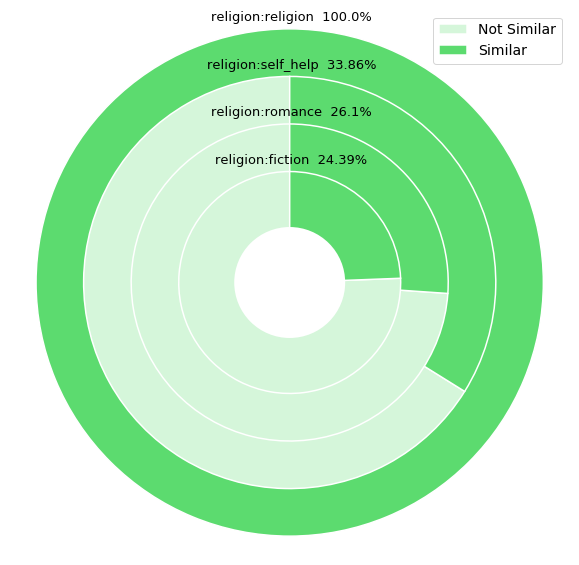

None


In [43]:
print(jaccard_plot(jaccard_df))

---

**Hope to hear your ideas on this. Happy Coding!!!**